In [699]:
#import the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
from datetime import datetime
pd.options.display.float_format = '{:.2f}'.format

In [700]:
#read the loan data file
loan_data = pd.read_csv('loan.csv',encoding = "unicode_escape", low_memory=False)

In [701]:
loan_data.shape

(39717, 111)

In [702]:
loan_data.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,1077501,1296599,5000,5000,4975.00,36 months,10.65%,162.87,B,B2,...,NaN,NaN,NaN,NaN,0.00,0.00,NaN,NaN,NaN,NaN
1,1077430,1314167,2500,2500,2500.00,60 months,15.27%,59.83,C,C4,...,NaN,NaN,NaN,NaN,0.00,0.00,NaN,NaN,NaN,NaN
2,1077175,1313524,2400,2400,2400.00,36 months,15.96%,84.33,C,C5,...,NaN,NaN,NaN,NaN,0.00,0.00,NaN,NaN,NaN,NaN
3,1076863,1277178,10000,10000,10000.00,36 months,13.49%,339.31,C,C1,...,NaN,NaN,NaN,NaN,0.00,0.00,NaN,NaN,NaN,NaN
4,1075358,1311748,3000,3000,3000.00,60 months,12.69%,67.79,B,B5,...,NaN,NaN,NaN,NaN,0.00,0.00,NaN,NaN,NaN,NaN


### DATA CLEANING

In [703]:
#Remove columns with 80% NULL values
nullcoulmns = loan_data.columns[round(100*(loan_data.isnull().sum()/len(loan_data.index)), 2) > 80]
loan_data=loan_data.drop(nullcoulmns,axis=1)
loan_data.shape

(39717, 55)

In [704]:
# Drop column which is not required(After checking loan csv file)
loan_data = loan_data.drop(['pymnt_plan', 'url', 'desc', 'title', 'zip_code', 'initial_list_status',
                  'collections_12_mths_ex_med', 'policy_code', 'application_type', 'acc_now_delinq', 'chargeoff_within_12_mths',
                  'delinq_amnt','tax_liens'], axis = 1)
loan_data.shape

(39717, 42)

In [705]:
column=round(100*(loan_data.isnull().sum()/len(loan_data.index)), 2)
column[column > 0]

emp_title                 6.19
emp_length                2.71
mths_since_last_delinq   64.66
revol_util                0.13
last_pymnt_d              0.18
last_credit_pull_d        0.01
pub_rec_bankruptcies      1.75
dtype: float64

In [706]:
# drop mths_since_last_delinq column (It should be biased if we predict with ~65 Null value)
#(Payment delinquency is commonly used to describe a situation in which a borrower misses a single payment) 
loan_data = loan_data.drop(['mths_since_last_delinq'],axis = 1)
loan_data.shape

(39717, 41)

In [707]:
##Employment length in years.
#Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years.
loan_data['emp_length'] = loan_data['emp_length'].replace(['10+ years','< 1 year'],['10 years','0 year'])

In [708]:
loan_data['emp_length'].value_counts()

10 years    8879
0 year      4583
2 years     4388
3 years     4095
4 years     3436
5 years     3282
1 year      3240
6 years     2229
7 years     1773
8 years     1479
9 years     1258
Name: emp_length, dtype: int64

In [709]:
## create bin for loan amount
loan_data['loan_amnt_bin'] = pd.cut(loan_data['loan_amnt'], 
                               [x for x in range(0, 36000, 5000)], labels=[str(x)+'-'+str(x+5)+'k' for x in range (0, 35, 5)])

In [710]:
loan_data['loan_amnt_bin'].value_counts()

5-10k     12960
0-5k       9568
10-15k     7986
15-20k     4591
20-25k     2999
30-35k      828
25-30k      785
Name: loan_amnt_bin, dtype: int64

In [711]:
## create bin for int rate
loan_data['int_rate'] = loan_data['int_rate'].apply(lambda x: float(x[:-1]))

In [712]:
loan_data['int_rate_bin'] = pd.cut(loan_data['int_rate'], bins = [5.00,10.00,15.00,20.00,25.00],
                        labels = ["5%-10%","11%-15%","16%-20%","21%-25%"])

In [713]:
loan_data['int_rate_bin'].value_counts()

11%-15%    18794
5%-10%     12393
16%-20%     7658
21%-25%      872
Name: int_rate_bin, dtype: int64

In [714]:
## create bin for installment
loan_data['installment'].describe()

count   39717.00
mean      324.56
std       208.87
min        15.69
25%       167.02
50%       280.22
75%       430.78
max      1305.19
Name: installment, dtype: float64

In [715]:
loan_data['installment_bin'] = pd.cut(loan_data['installment'], bins = [0.00,300.00,600.00,900.00,max(loan_data.installment)],
                        labels = ["0-300","300-600","600-900","900+"])

In [716]:
loan_data['installment_bin'].value_counts()

0-300      21095
300-600    14232
600-900     3846
900+         544
Name: installment_bin, dtype: int64

In [717]:
## create bin for annual_inc
loan_data['annual_inc'].describe()

count     39717.00
mean      68968.93
std       63793.77
min        4000.00
25%       40404.00
50%       59000.00
75%       82300.00
max     6000000.00
Name: annual_inc, dtype: float64

In [718]:
loan_data['annual_inc_bin'] = pd.cut(loan_data['annual_inc'], [0, 20000, 40000, 60000, 80000,100000,6000000],
                          labels=['0-20K', '21K-40K', '41K-60K', '61K-80K', '81K-100K','100K+'])


In [719]:
loan_data['annual_inc_bin'].value_counts()

41K-60K     11608
21K-40K      8688
61K-80K      7861
100K+        5687
81K-100K     4684
0-20K        1189
Name: annual_inc_bin, dtype: int64

In [720]:
## create bin for dti
loan_data['dti_bin'] = pd.cut(loan_data['dti'], bins = [0.00,5.00,10.00,15.00,20.00,25.00,30.00],
                        labels = ["0-5","6-10","11-15","16-20","21-25","26-30"])

In [721]:
loan_data['dti_bin'].value_counts()

11-15    9899
16-20    9095
6-10     8072
21-25    6815
0-5      4977
26-30     676
Name: dti_bin, dtype: int64

In [722]:
## create bin for revol_util
#Revolving utilization, also known as “credit utilization” or your “debt-to-limit ratio,”
#Utilization refers to how much of your credit balance you’re using at a given time.
loan_data['revol_util'].describe()

count     39667
unique     1089
top          0%
freq        977
Name: revol_util, dtype: object

In [723]:
#replacing null value with 0
loan_data['revol_util'] = loan_data['revol_util'].replace(np.nan,"0%")
loan_data['revol_util'] = loan_data['revol_util'].apply(lambda x: float(x[:-1]))

In [724]:
loan_data['revol_util'].describe()

count   39717.00
mean       48.77
std        28.37
min         0.00
25%        25.30
50%        49.20
75%        72.30
max        99.90
Name: revol_util, dtype: float64

In [725]:
loan_data['revol_util_bin'] = pd.cut(loan_data['revol_util'], bins = [0.00,20.00,40.00,60.00,80.00,100.00],
                        labels = ["0%-20%","21%-40%","41%-60%","61%-80%","81%-100%"])

In [726]:
loan_data['revol_util_bin'].value_counts()

41%-60%     8665
61%-80%     8300
21%-40%     7925
0%-20%      6939
81%-100%    6861
Name: revol_util_bin, dtype: int64

In [727]:
##issue_d
# Year in which the loan was funded
loan_data['issue_d_Year'] = pd.to_datetime(loan_data['issue_d'].apply(lambda x: datetime.strptime(x,'%b-%y'))).dt.strftime('%Y')

In [728]:
##issue_d
#  month which the loan was funded
loan_data['issue_d_Month'] = pd.to_datetime(loan_data['issue_d'].apply(lambda x: datetime.strptime(x,'%b-%y'))).dt.strftime('%b')

In [729]:
loan_data['issue_d_Year'].value_counts()

2011    21656
2010    11532
2009     4716
2008     1562
2007      251
Name: issue_d_Year, dtype: int64

In [730]:
loan_data['issue_d_Month'].value_counts()

Dec    4433
Nov    4167
Oct    3934
Sep    3648
Aug    3518
Jul    3476
Jun    3279
May    2999
Apr    2834
Mar    2692
Jan    2379
Feb    2358
Name: issue_d_Month, dtype: int64

In [731]:
## create bin for open_acc (The number of open credit lines in the borrower's credit file.)
# A line of credit (LOC) is a preset borrowing limit that can be used at any time.
# The borrower can take money out as needed until the limit is reached, and as money is repaid,
# it can be borrowed again in the case of an open line of credit.

#Remove row where open_acc is greater than total_acc
loan_data= loan_data[~(loan_data.open_acc > loan_data.total_acc)]

In [732]:
loan_data['open_acc_bin'] = pd.cut(loan_data['open_acc'], bins = [0,10,20,30,40,50],
                        labels = ["0-10","11-20","21-30","31-40","41-50"])

In [733]:
loan_data['open_acc_bin'].value_counts()

0-10     26465
11-20    12492
21-30      729
31-40       27
41-50        3
Name: open_acc_bin, dtype: int64

In [734]:
##create bin for total_acc
loan_data['total_acc_bin'] = pd.cut(loan_data['total_acc'], bins = [0,20,40,60,80,100],
                        labels = ["0-20","21-40","41-60","61-80","81-100"])

In [735]:
loan_data['total_acc_bin'].value_counts()

0-20      19961
21-40     16968
41-60      2577
61-80       207
81-100        3
Name: total_acc_bin, dtype: int64

### Sanity Check

In [736]:
#check unique values in id and member id column
loan_id = len(loan_data['id'].unique())
member_id = len(loan_data['member_id'].unique())
loan_id , member_id

(39716, 39716)

In [737]:
#check whether funded amount is greater than loan amount
loan_data[(loan_data.funded_amnt > loan_data.loan_amnt)].shape

(0, 51)

In [738]:
#check whether funded amount inv is greater than loan amount
loan_data[(loan_data.funded_amnt_inv > loan_data.loan_amnt)].shape

(0, 51)

In [739]:
#check whether installement is greater than loan amount
loan_data[(loan_data.installment > loan_data.loan_amnt)].shape

(0, 51)

In [740]:
print(len(loan_data.columns))
loan_data.columns

51


Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title',
       'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
       'issue_d', 'loan_status', 'purpose', 'addr_state', 'dti', 'delinq_2yrs',
       'earliest_cr_line', 'inq_last_6mths', 'open_acc', 'pub_rec',
       'revol_bal', 'revol_util', 'total_acc', 'out_prncp', 'out_prncp_inv',
       'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_d', 'last_pymnt_amnt', 'last_credit_pull_d',
       'pub_rec_bankruptcies', 'loan_amnt_bin', 'int_rate_bin',
       'installment_bin', 'annual_inc_bin', 'dti_bin', 'revol_util_bin',
       'issue_d_Year', 'issue_d_Month', 'open_acc_bin', 'total_acc_bin'],
      dtype='object')

In [741]:
#Chrgedoff dataframe
chargedoff_data = loan_data[loan_data['loan_status']=="Charged Off"]

In [742]:
# Remove column that are not needed for analysis
col =['id', 'member_id','emp_title','addr_state']
loan_data = loan_data.drop(col,axis=1)

In [743]:
loan_data.shape

(39716, 47)

## Univariante Analysis

### Loan_status


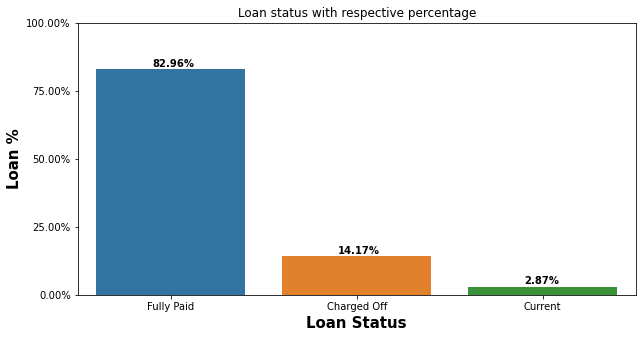

In [744]:
#Loan status with respective percentage present in the dataset
def count_plot(dataframe,col):
    plt.figure(figsize=(10,5))
    ax=sns.countplot(x=dataframe[col])
    totalrow = dataframe.shape[0]

    plt.xlabel('Loan Status',fontweight ='bold',fontsize = 15)
    plt.ylabel('Loan %',fontweight ='bold',fontsize = 15)
    plt.title('Loan status with respective percentage')
    for p in ax.patches:
        ax.annotate('{:.2f}%'.format(100*p.get_height()/totalrow), (p.get_x()+0.3, p.get_height()+0.01 * totalrow),fontweight ='bold')
    
    ax.yaxis.set_ticks(np.linspace(0, totalrow, 5))
    
    _ = ax.set_yticklabels(map('{:.2f}%'.format, 100*ax.yaxis.get_majorticklocs()/totalrow))
    plt.show()
count_plot(loan_data,'loan_status')

- Only 2.87% of Total Loan is in Current status.

In [745]:
# Remove the rows which have loan status as current.
# Can't make analysis for loans which are on "current" status
loan_data = loan_data[~(loan_data['loan_status']=='Current')]

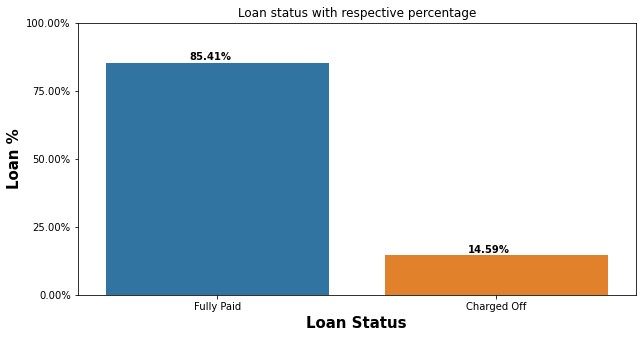

In [746]:
count_plot(loan_data,'loan_status')

- 85.41% of total loan is Paid and 14.59% of total loan is Charged off

#### Variable: loan_amnt


In [747]:
loan_data['loan_amnt'].describe()

count   38576.00
mean    11047.26
std      7348.39
min       500.00
25%      5300.00
50%      9600.00
75%     15000.00
max     35000.00
Name: loan_amnt, dtype: float64

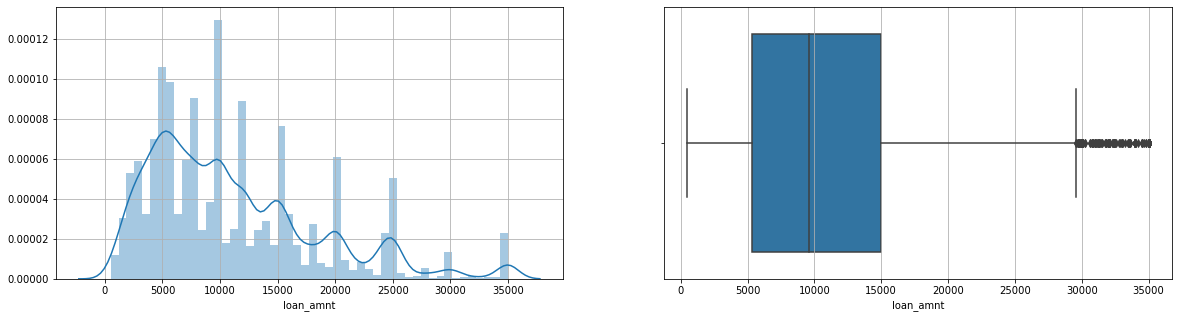

In [748]:
#Dist and box plot to know the distribution of loan_amnt
def plot_distribution(dataframe, col):
    plt.figure(figsize=(20,5)) 
    plt.subplot(1, 2, 1)
    plt.grid()
    ax = sns.distplot(dataframe[col])
    plt.subplot(1, 2, 2)
    plt.grid()
    sns.boxplot(x=dataframe[col], data=dataframe)
    plt.show()

plot_distribution(loan_data, 'loan_amnt')

In [749]:
loan_data.groupby('loan_amnt_bin')['loan_status'].value_counts(normalize=True) * 100

loan_amnt_bin  loan_status
0-5k           Fully Paid    86.13
               Charged Off   13.87
5-10k          Fully Paid    87.17
               Charged Off   12.83
10-15k         Fully Paid    86.27
               Charged Off   13.73
15-20k         Fully Paid    82.73
               Charged Off   17.27
20-25k         Fully Paid    80.89
               Charged Off   19.11
25-30k         Fully Paid    79.57
               Charged Off   20.43
30-35k         Fully Paid    75.51
               Charged Off   24.49
Name: loan_status, dtype: float64

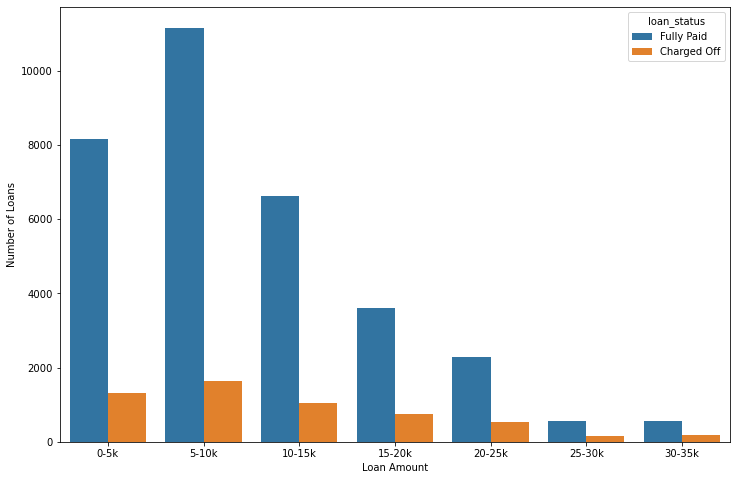

In [750]:
#Number of loan taken for loan amount range and there loan status
plt.figure(figsize=(12, 8))
s=sns.barplot(x='loan_amnt_bin', y='loan_amnt', hue="loan_status", data=loan_data, estimator=lambda x:len(x))
s.set(xlabel='Loan Amount', ylabel='Number of Loans')
plt.show()

- Most loan taken in 5000 - 10,000 range
- For higher Loan amount there is less number of loan but high chance of charge off
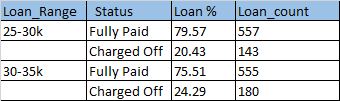

#### Variable: 
- funded_amnt -The total amount committed to that loan at that point in time.
- funded_amnt_inv - The total amount committed by investors for that loan at that point in time.

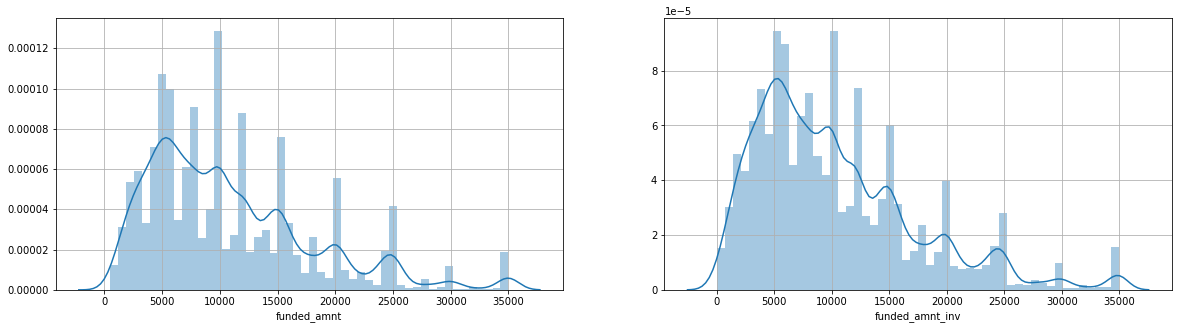

In [751]:
# distplot for the funded_amnt and funded_amnt_inv
plt.figure(figsize=(20,5))
plt.subplot(1, 2, 1)
plt.grid()
ax = sns.distplot(loan_data['funded_amnt'])
plt.subplot(1, 2, 2)
plt.grid()
ax = sns.distplot(loan_data['funded_amnt_inv'])
plt.show()

observatio:
- Both funded_amnt and funded_amnt_inv are right skew graph

#### Variable : term

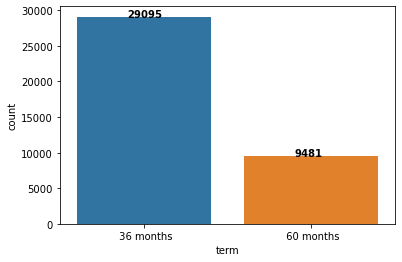

In [752]:
#Number of loan for the respective term
ax=sns.countplot(x=loan_data['term'])
for p in ax.patches:
        ax.annotate((p.get_height()), (p.get_x()+0.3, p.get_height()),fontweight ='bold')

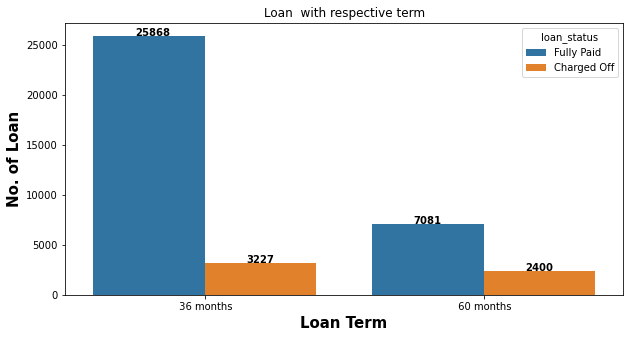

In [753]:
#Number of loan for the term as per loan status
plt.figure(figsize=(10,5))
ax=sns.countplot(x=loan_data['term'],hue=loan_data['loan_status'])
plt.xlabel('Loan Term',fontweight ='bold',fontsize = 15)
plt.ylabel('No. of Loan',fontweight ='bold',fontsize = 15)
plt.title('Loan  with respective term')
for p in ax.patches:
        ax.annotate((p.get_height()), (p.get_x()+0.15, p.get_height()),fontweight ='bold')

In [754]:
loan_data.groupby('term')['loan_status'].value_counts(normalize=True) * 100

term        loan_status
 36 months  Fully Paid    88.91
            Charged Off   11.09
 60 months  Fully Paid    74.69
            Charged Off   25.31
Name: loan_status, dtype: float64

##### Observation:
- Most loan taken for 36 months.
- For 60 months loan term there is 25.31% charged off

#### variable: int_rate

In [755]:
loan_data['int_rate'].describe()

count   38576.00
mean       11.93
std         3.69
min         5.42
25%         8.94
50%        11.71
75%        14.38
max        24.40
Name: int_rate, dtype: float64

In [756]:
loan_data.groupby('int_rate_bin')['loan_status'].value_counts(normalize = True) * 100

int_rate_bin  loan_status
5%-10%        Fully Paid    93.26
              Charged Off    6.74
11%-15%       Fully Paid    85.18
              Charged Off   14.82
16%-20%       Fully Paid    75.17
              Charged Off   24.83
21%-25%       Fully Paid    61.56
              Charged Off   38.44
Name: loan_status, dtype: float64

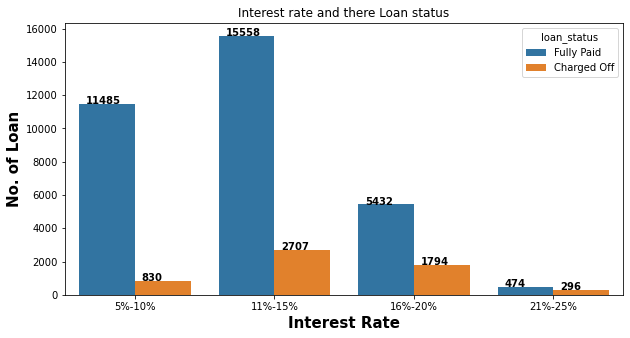

In [757]:
#Interest rate for which loans are given and there loan status.
plt.figure(figsize=(10,5))
ax=sns.countplot(x=loan_data['int_rate_bin'],hue=loan_data['loan_status'])
plt.xlabel('Interest Rate',fontweight ='bold',fontsize = 15)
plt.ylabel('No. of Loan',fontweight ='bold',fontsize = 15)
plt.title('Interest rate and there Loan status')
for p in ax.patches:
        ax.annotate((p.get_height()), (p.get_x()+0.05, p.get_height()),fontweight ='bold')

###### Observation:
- Most loan are given between 11% to 15% interest rate
- For higher interest rate(21%-25%) there are total 770 loan are given out of which 296 (38.44%) charged off.
  

#### Variable: installment

In [758]:
loan_data['installment'].describe()

count   38576.00
mean      322.47
std       208.64
min        15.69
25%       165.74
50%       277.86
75%       425.55
max      1305.19
Name: installment, dtype: float64

In [759]:
loan_data.groupby('installment_bin')['loan_status'].value_counts(normalize = True) * 100

installment_bin  loan_status
0-300            Fully Paid    86.07
                 Charged Off   13.93
300-600          Fully Paid    85.08
                 Charged Off   14.92
600-900          Fully Paid    83.57
                 Charged Off   16.43
900+             Fully Paid    81.15
                 Charged Off   18.85
Name: loan_status, dtype: float64

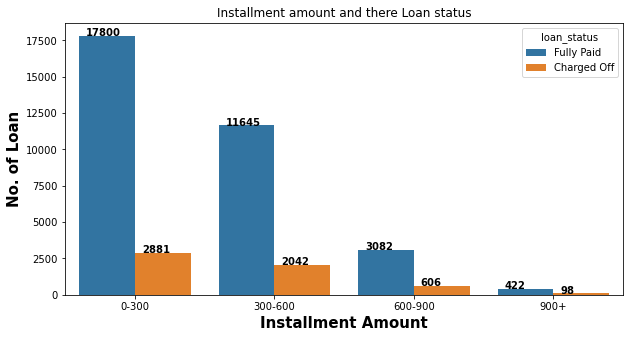

In [760]:
#Installment amount of loan and there loan status
plt.figure(figsize=(10,5))
ax=sns.countplot(x=loan_data['installment_bin'],hue=loan_data['loan_status'])
plt.xlabel('Installment Amount',fontweight ='bold',fontsize = 15)
plt.ylabel('No. of Loan',fontweight ='bold',fontsize = 15)
plt.title('Installment amount and there Loan status')
for p in ax.patches:
        ax.annotate((p.get_height()), (p.get_x()+0.05, p.get_height()),fontweight ='bold')

##### Observation:
- Nothing to be concluded from the installment amount

#### Variable: grade

In [761]:
loan_data['grade'].value_counts()

B    11675
A    10044
C     7834
D     5085
E     2663
F      976
G      299
Name: grade, dtype: int64

In [762]:
loan_data.groupby('grade')['loan_status'].value_counts(normalize = True) * 100

grade  loan_status
A      Fully Paid    94.01
       Charged Off    5.99
B      Fully Paid    87.79
       Charged Off   12.21
C      Fully Paid    82.81
       Charged Off   17.19
D      Fully Paid    78.01
       Charged Off   21.99
E      Fully Paid    73.15
       Charged Off   26.85
F      Fully Paid    67.32
       Charged Off   32.68
G      Fully Paid    66.22
       Charged Off   33.78
Name: loan_status, dtype: float64

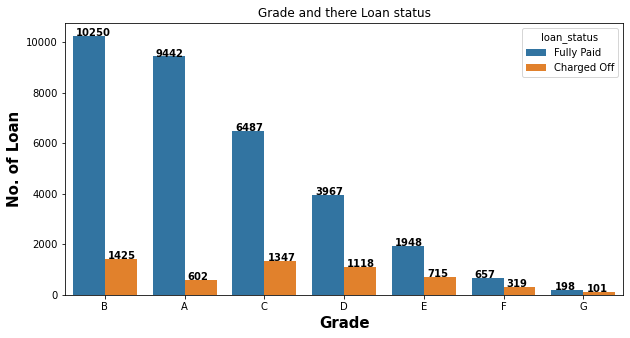

In [763]:
#Grade for the laon and there loan_status
plt.figure(figsize=(10,5))
ax=sns.countplot(x=loan_data['grade'],hue=loan_data['loan_status'],order=loan_data['grade'].value_counts().index)
plt.xlabel('Grade',fontweight ='bold',fontsize = 15)
plt.ylabel('No. of Loan',fontweight ='bold',fontsize = 15)
plt.title('Grade and there Loan status')
for p in ax.patches:
        ax.annotate((p.get_height()), (p.get_x()+0.04, p.get_height()),fontweight ='bold')

##### Observation:
- There are less number of loan for grade E, F, and G but high percentage of charged off.
- For grade F  there is 32.68% charged off and for grade G there is 33.78%  charged off. 

#### Variable: sub_grade

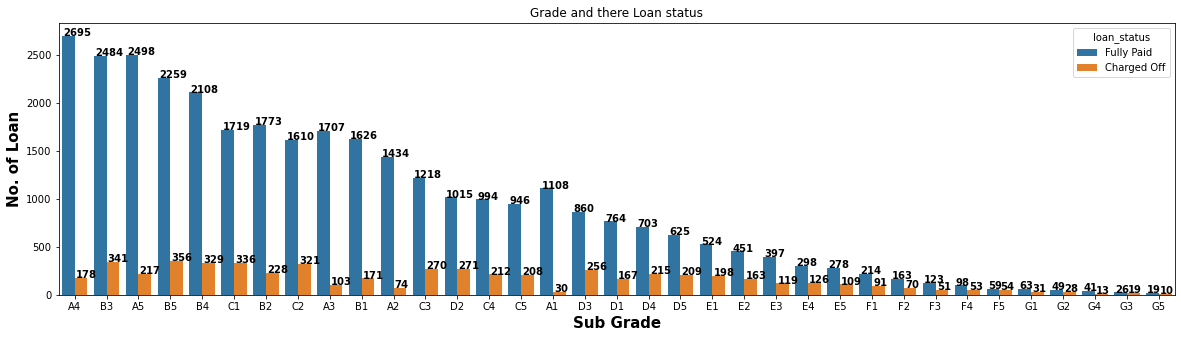

In [764]:
#Subgrade as per loan count and there loan status
plt.figure(figsize=(20,5))
ax=sns.countplot(x=loan_data['sub_grade'],hue=loan_data['loan_status'],order=loan_data['sub_grade'].value_counts().index)
plt.xlabel('Sub Grade',fontweight ='bold',fontsize = 15)
plt.ylabel('No. of Loan',fontweight ='bold',fontsize = 15)
plt.title('Grade and there Loan status')
for p in ax.patches:
        ax.annotate((p.get_height()), (p.get_x()+0.04, p.get_height()),fontweight ='bold')

##### Observation:
- For sub grade between E to G there is very less number of loan but high percentage of charged off

#### Variable:emp_length

In [765]:
loan_data.groupby('emp_length')['loan_status'].value_counts(normalize=True) * 100

emp_length  loan_status
0 year      Fully Paid    85.83
            Charged Off   14.17
1 year      Fully Paid    85.61
            Charged Off   14.39
10 years    Fully Paid    84.32
            Charged Off   15.68
2 years     Fully Paid    86.79
            Charged Off   13.21
3 years     Fully Paid    86.17
            Charged Off   13.83
4 years     Fully Paid    86.18
            Charged Off   13.82
5 years     Fully Paid    85.66
            Charged Off   14.34
6 years     Fully Paid    85.84
            Charged Off   14.16
7 years     Fully Paid    84.63
            Charged Off   15.37
8 years     Fully Paid    85.85
            Charged Off   14.15
9 years     Fully Paid    87.11
            Charged Off   12.89
Name: loan_status, dtype: float64

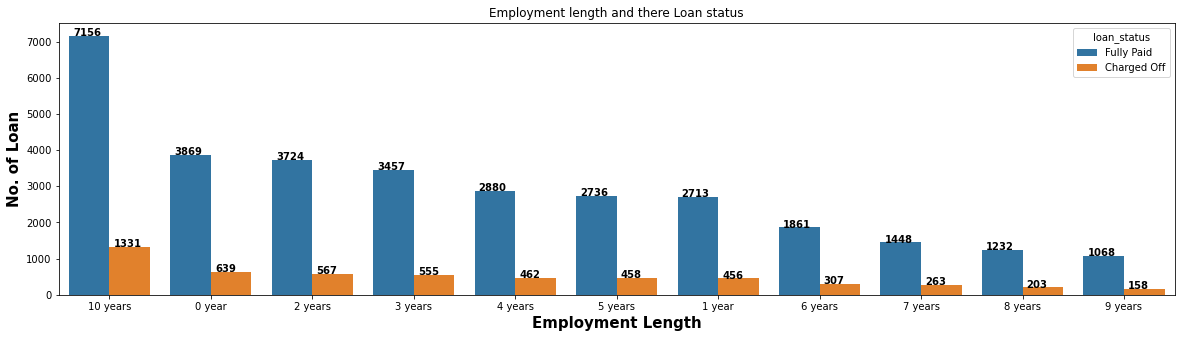

In [766]:
#Loan count as per employment length and there loan status
plt.figure(figsize=(20,5))
ax=sns.countplot(x=loan_data['emp_length'],hue=loan_data['loan_status'],order=loan_data['emp_length'].value_counts().index)
plt.xlabel('Employment Length',fontweight ='bold',fontsize = 15)
plt.ylabel('No. of Loan',fontweight ='bold',fontsize = 15)
plt.title('Employment length and there Loan status')
for p in ax.patches:
        ax.annotate((p.get_height()), (p.get_x()+0.04, p.get_height()),fontweight ='bold')

##### Observation:
- Most number of loan taken by people who have 10 or 10+ year of employment

#### Variable:home_ownership

In [767]:
loan_data.groupby('home_ownership')['loan_status'].value_counts(normalize=True) * 100

home_ownership  loan_status
MORTGAGE        Fully Paid     86.33
                Charged Off    13.67
NONE            Fully Paid    100.00
OTHER           Fully Paid     81.63
                Charged Off    18.37
OWN             Fully Paid     85.11
                Charged Off    14.89
RENT            Fully Paid     84.64
                Charged Off    15.36
Name: loan_status, dtype: float64

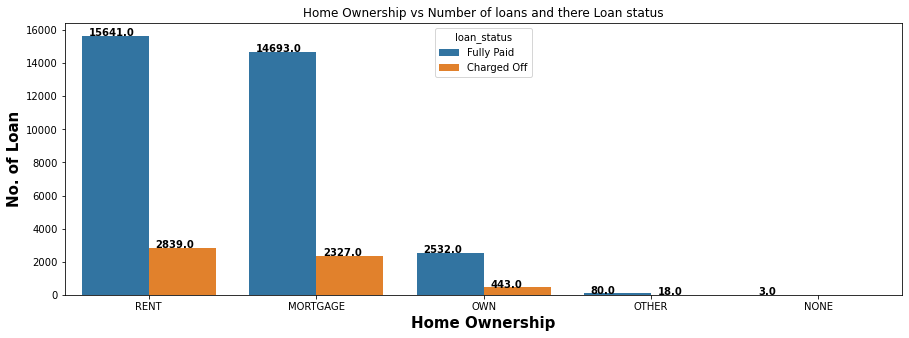

In [768]:
#Number of loan as per borrower home ownership and there loan status.
plt.figure(figsize=(15,5))
ax=sns.countplot(x=loan_data['home_ownership'],hue=loan_data['loan_status'],order=loan_data['home_ownership'].value_counts().index)
plt.xlabel('Home Ownership',fontweight ='bold',fontsize = 15)
plt.ylabel('No. of Loan',fontweight ='bold',fontsize = 15)
plt.title('Home Ownership vs Number of loans and there Loan status')
for p in ax.patches:
        ax.annotate((p.get_height()), (p.get_x()+0.04, p.get_height()),fontweight ='bold')

##### Observation: 
- Most number of loan are taken people who have home ownership as Rent or Mortgage

#### Variable: annual_inc

In [769]:
loan_data['annual_inc'].describe()

count     38576.00
mean      68776.70
std       64219.03
min        4000.00
25%       40000.00
50%       58860.28
75%       82000.00
max     6000000.00
Name: annual_inc, dtype: float64

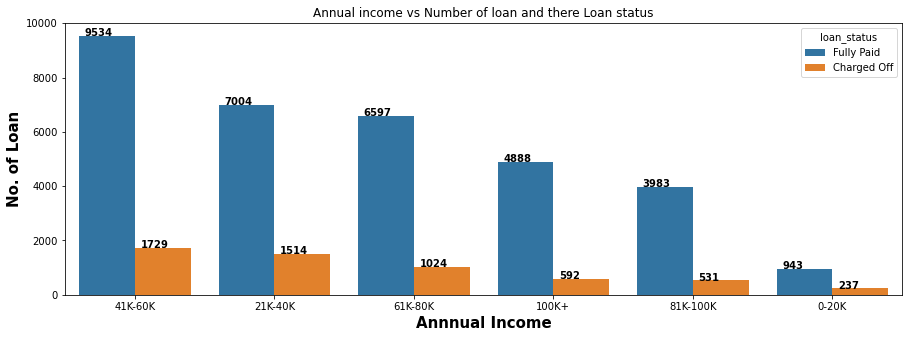

In [770]:
#Number of loan as per borrower annual income and there loan status.
plt.figure(figsize=(15,5))
ax=sns.countplot(x=loan_data['annual_inc_bin'],hue=loan_data['loan_status'],order=loan_data['annual_inc_bin'].value_counts().index)
plt.xlabel('Annnual Income',fontweight ='bold',fontsize = 15)
plt.ylabel('No. of Loan',fontweight ='bold',fontsize = 15)
plt.title('Annual income vs Number of loan and there Loan status')
for p in ax.patches:
        ax.annotate((p.get_height()), (p.get_x()+0.04, p.get_height()),fontweight ='bold')

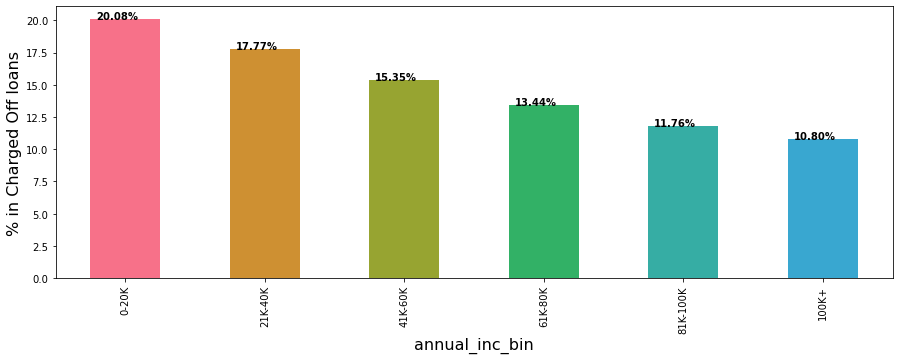

In [771]:
#percentage of charged off loans as per Annual income range
def plot_percentages(dataframe, by, sortbyindex=False):
    plt.figure(figsize=(15,5))
    values = ((dataframe.loc[dataframe['loan_status']=='Charged Off'][by].value_counts())/
             (dataframe[by].value_counts())) * 100
    values = values.sort_values(ascending=False)
    ax = values.plot.bar(color=sns.color_palette('husl', 8))
    ax.set_ylabel('% in Charged Off loans', fontsize=16)
    ax.set_xlabel(by,fontsize=16)
    for p in ax.patches:
        ax.annotate('{:.2f}%'.format(p.get_height()), (p.get_x()+0.04, p.get_height()),fontweight ='bold')
plot_percentages(loan_data,'annual_inc_bin')

##### Observation:
- People with low income has a high percentage of charged off
- Annual income under 20K have 20.08% charged off.

#### Variable:verification_status
Indicates if income was verified by LC, not verified, or if the income source was verified

In [772]:
loan_data.groupby('verification_status')['loan_status'].value_counts(normalize=True) * 100

verification_status  loan_status
Not Verified         Fully Paid    87.17
                     Charged Off   12.83
Source Verified      Fully Paid    85.18
                     Charged Off   14.82
Verified             Fully Paid    83.20
                     Charged Off   16.80
Name: loan_status, dtype: float64

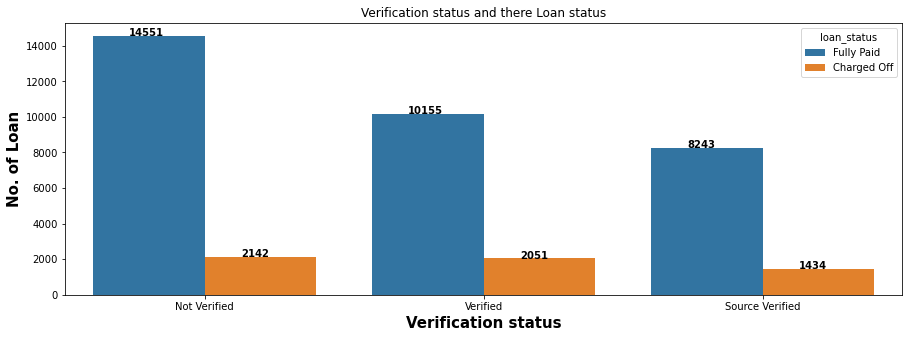

In [773]:
#Number of loan given as per the verifiaction of borrower annual income and there loan status.
plt.figure(figsize=(15,5))
ax=sns.countplot(x=loan_data['verification_status'],hue=loan_data['loan_status'],order=loan_data['verification_status'].value_counts().index)
plt.xlabel('Verification status',fontweight ='bold',fontsize = 15)
plt.ylabel('No. of Loan',fontweight ='bold',fontsize = 15)
plt.title('Verification status and there Loan status')
for p in ax.patches:
        ax.annotate((p.get_height()), (p.get_x()+0.13, p.get_height()),fontweight ='bold')

##### Observation:
Most Loan are given without verifying the Annual income

#### Variable: issued_d_Year
The year in  which the loan was funded

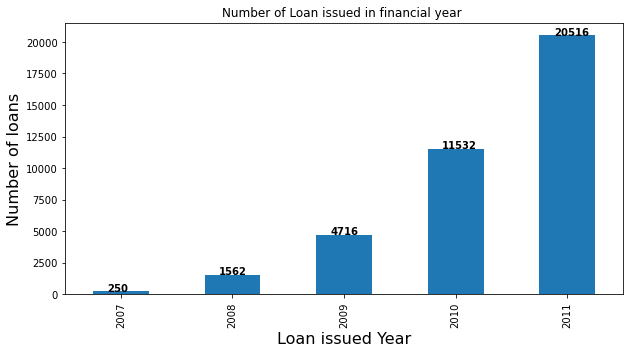

In [774]:
#Number of loan issued in a Year.
ax=loan_data['issue_d_Year'].value_counts().sort_values(ascending=True)
plt.figure(figsize=(10,5))
ax=ax.plot.bar()
ax.set_ylabel('Number of loans', fontsize=16)
ax.set_xlabel('Loan issued Year',fontsize=16)
plt.title('Number of Loan issued in financial year ')
for p in ax.patches:
        ax.annotate((p.get_height()), (p.get_x()+0.13, p.get_height()),fontweight ='bold')
plt.show()

In [775]:
loan_data.groupby('issue_d_Year')['loan_status'].value_counts(normalize=True)*100

issue_d_Year  loan_status
2007          Fully Paid    82.00
              Charged Off   18.00
2008          Fully Paid    84.19
              Charged Off   15.81
2009          Fully Paid    87.40
              Charged Off   12.60
2010          Fully Paid    87.12
              Charged Off   12.88
2011          Fully Paid    84.13
              Charged Off   15.87
Name: loan_status, dtype: float64

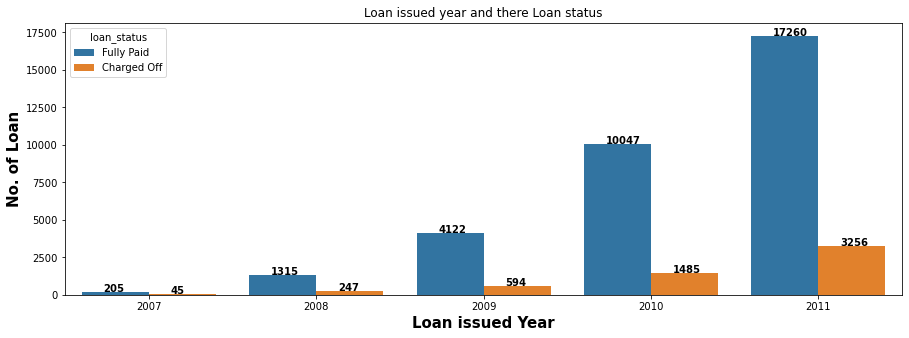

In [776]:
#Year wise loan count and there loan status
plt.figure(figsize=(15,5))
ax=sns.countplot(x=loan_data['issue_d_Year'],hue=loan_data['loan_status'])
plt.xlabel('Loan issued Year',fontweight ='bold',fontsize = 15)
plt.ylabel('No. of Loan',fontweight ='bold',fontsize = 15)
plt.title('Loan issued year and there Loan status')
for p in ax.patches:
        ax.annotate((p.get_height()), (p.get_x()+0.13, p.get_height()),fontweight ='bold')

##### Observation:
- Number of loans increases as per Year

#### Variable: issue_d_Month

In [777]:
loan_data.groupby('issue_d_Month')['loan_status'].value_counts(normalize=True) * 100

issue_d_Month  loan_status
Apr            Fully Paid    86.93
               Charged Off   13.07
Aug            Fully Paid    86.19
               Charged Off   13.81
Dec            Fully Paid    83.91
               Charged Off   16.09
Feb            Fully Paid    87.70
               Charged Off   12.30
Jan            Fully Paid    86.51
               Charged Off   13.49
Jul            Fully Paid    85.71
               Charged Off   14.29
Jun            Fully Paid    84.81
               Charged Off   15.19
Mar            Fully Paid    87.11
               Charged Off   12.89
May            Fully Paid    84.04
               Charged Off   15.96
Nov            Fully Paid    85.07
               Charged Off   14.93
Oct            Fully Paid    84.58
               Charged Off   15.42
Sep            Fully Paid    84.36
               Charged Off   15.64
Name: loan_status, dtype: float64

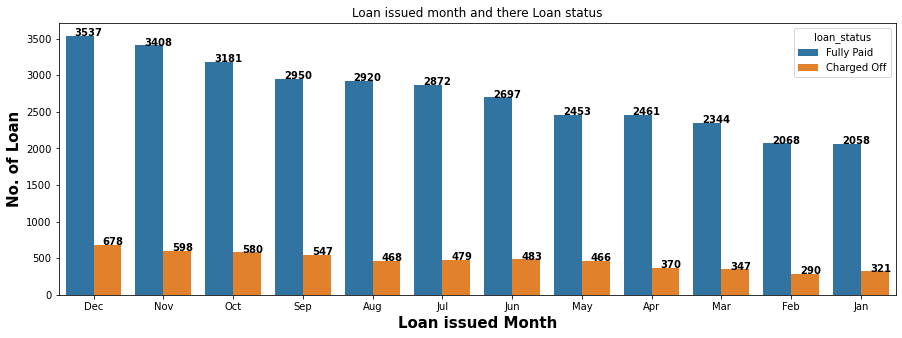

In [778]:
#Number of loan as per month and there loan status
plt.figure(figsize=(15,5))
ax=sns.countplot(x=loan_data['issue_d_Month'],hue=loan_data['loan_status'])
plt.xlabel('Loan issued Month',fontweight ='bold',fontsize = 15)
plt.ylabel('No. of Loan',fontweight ='bold',fontsize = 15)
plt.title('Loan issued month and there Loan status')
for p in ax.patches:
        ax.annotate((p.get_height()), (p.get_x()+0.13, p.get_height()),fontweight ='bold')

##### Observation:
- Most of the loan taken in Q4 (Dec,Nov, and Oct)

#### Variable:purpose

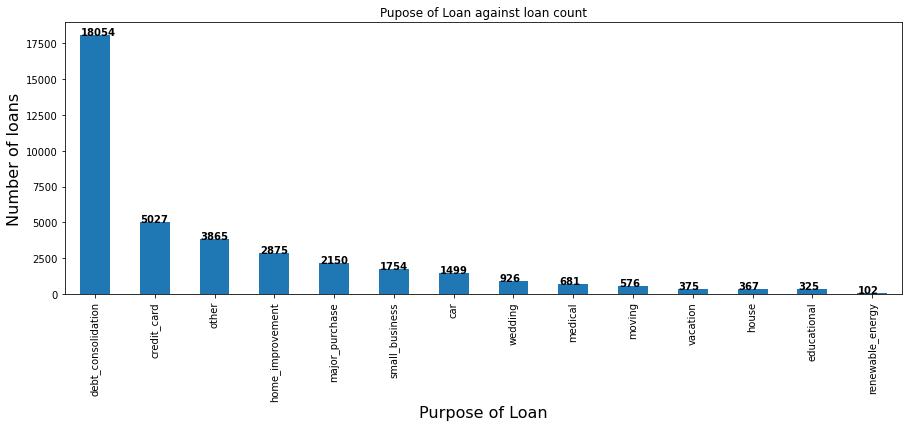

In [779]:
#Pupose of Loan against loan count
ax=loan_data['purpose'].value_counts().sort_values(ascending=False)
plt.figure(figsize=(15,5))
ax=ax.plot.bar()
ax.set_ylabel('Number of loans', fontsize=16)
ax.set_xlabel('Purpose of Loan',fontsize=16)
plt.title('Pupose of Loan against loan count')
for p in ax.patches:
        ax.annotate((p.get_height()), (p.get_x()+0.01, p.get_height()),fontweight ='bold')
plt.show()

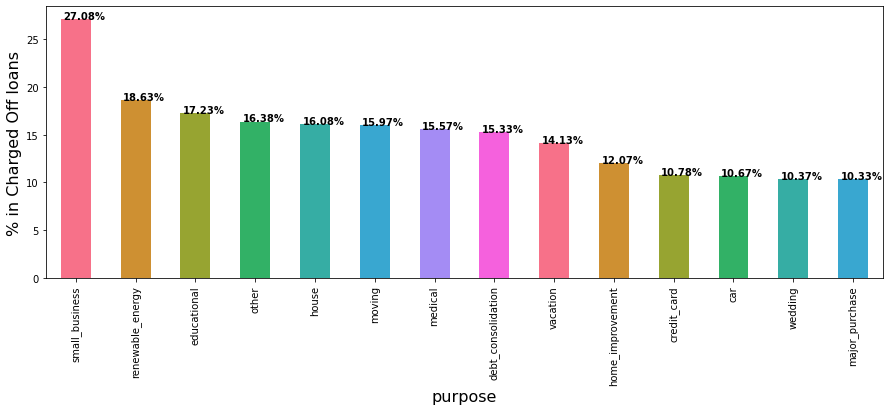

In [780]:
#percentage of charged off loan for the purpose
plot_percentages(loan_data,'purpose')

##### Observation:
- Maximum loan(18054) are taken for debt consolidation 
- Maximum charged_off(27.08%) is for small business out of total 1754 loan

#### Variable: dti
A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage
and the requested LC loan, divided by the borrower’s self-reported monthly income.

In [781]:
loan_data['dti'].describe()

count   38576.00
mean       13.27
std         6.67
min         0.00
25%         8.13
50%        13.37
75%        18.56
max        29.99
Name: dti, dtype: float64

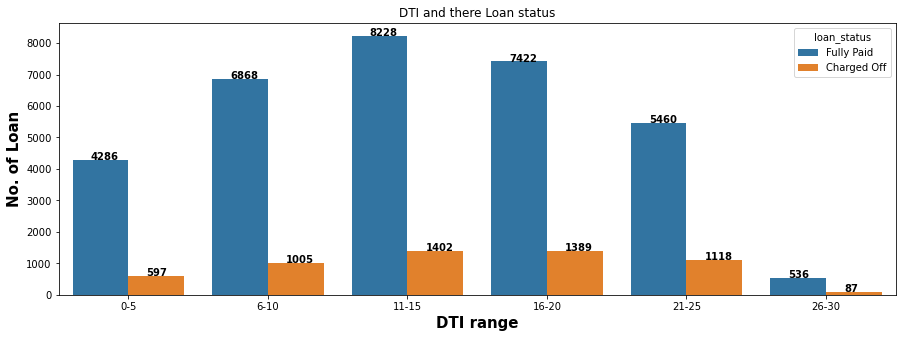

In [782]:
#dti range agains loan status
plt.figure(figsize=(15,5))
ax=sns.countplot(x=loan_data['dti_bin'],hue=loan_data['loan_status'])
plt.xlabel('DTI range',fontweight ='bold',fontsize = 15)
plt.ylabel('No. of Loan',fontweight ='bold',fontsize = 15)
plt.title('DTI and there Loan status')
for p in ax.patches:
        ax.annotate((p.get_height()), (p.get_x()+0.13, p.get_height()),fontweight ='bold')

Text(0.5, 0, 'DTI range')

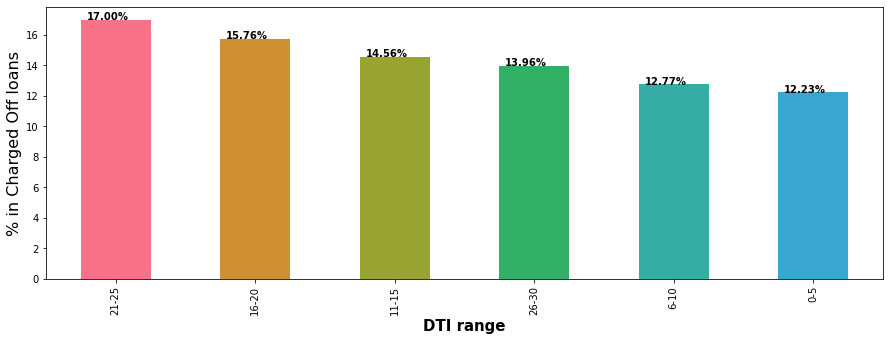

In [783]:
#Percentage of charged off for dti
plot_percentages(loan_data,'dti_bin')
plt.xlabel('DTI range',fontweight ='bold',fontsize = 15)

##### Observation:
- Most loan are in between 6 to 20 dti
- For dti in range 21-25 there is 17.00% chargedoff.

#### Variable:delinq_2yrs
The number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years

In [784]:
loan_data['delinq_2yrs'].value_counts()

0     34385
1      3207
2       673
3       212
4        60
5        21
6        10
7         4
8         2
9         1
11        1
Name: delinq_2yrs, dtype: int64

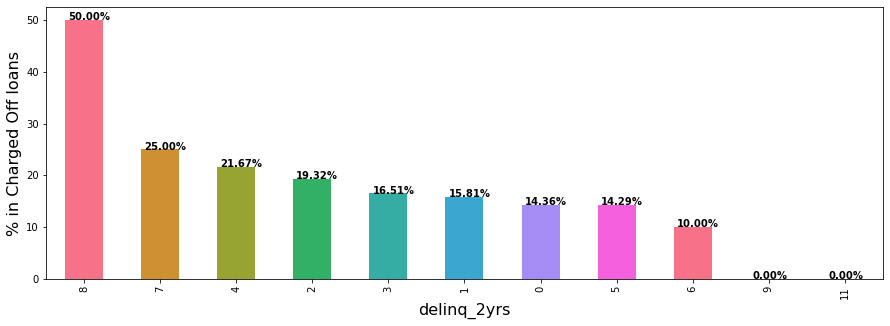

In [785]:
#Percentage of charged off for delinq_2yrs
plot_percentages(loan_data,'delinq_2yrs')

##### Observation:
- Most borrower have delinquency of 0

#### Variable: inq_last_6mths
The number of inquiries in past 6 months (excluding auto and mortgage inquiries)

In [786]:
loan_data['inq_last_6mths'].value_counts()

0    18708
1    10660
2     5654
3     2983
4      316
5      144
6       63
7       34
8       14
Name: inq_last_6mths, dtype: int64

Text(0.5, 0, 'Inquiries in past 6 months')

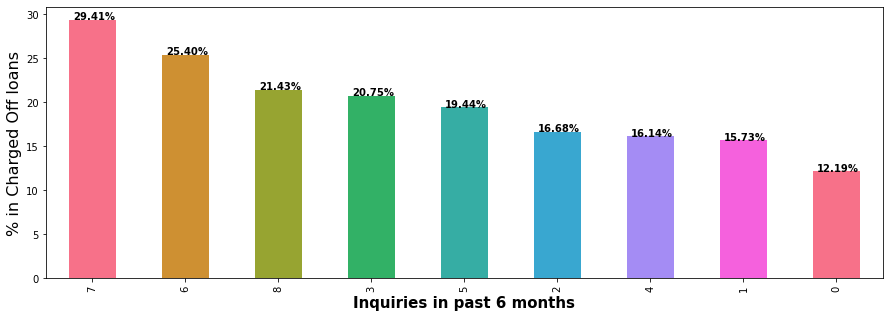

In [787]:
#Percentage of charged off for inq_last_6mnths
plot_percentages(loan_data,'inq_last_6mths')
plt.xlabel( 'Inquiries in past 6 months',fontweight ='bold',fontsize = 15)

#### Variable : open_acc
The number of open credit lines in the borrower's credit file.

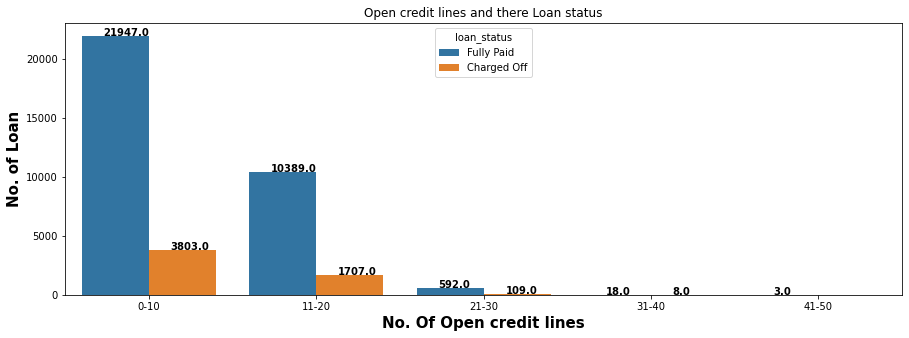

In [788]:
# Number of loans for Open credit lines against loan status
plt.figure(figsize=(15,5))
ax=sns.countplot(x=loan_data['open_acc_bin'],hue=loan_data['loan_status'])
plt.xlabel('No. Of Open credit lines',fontweight ='bold',fontsize = 15)
plt.ylabel('No. of Loan',fontweight ='bold',fontsize = 15)
plt.title('Open credit lines and there Loan status')
for p in ax.patches:
        ax.annotate((p.get_height()), (p.get_x()+0.13, p.get_height()),fontweight ='bold')

##### Observation:
- Most borrower in the dataset have less than 10 open_acc

#### Variable: pub_rec
Number of derogatory public records

In [789]:
loan_data['pub_rec'].value_counts()

0    36506
1     2013
2       48
3        7
4        2
Name: pub_rec, dtype: int64

Text(0.5, 0, 'Number of derogatory public records')

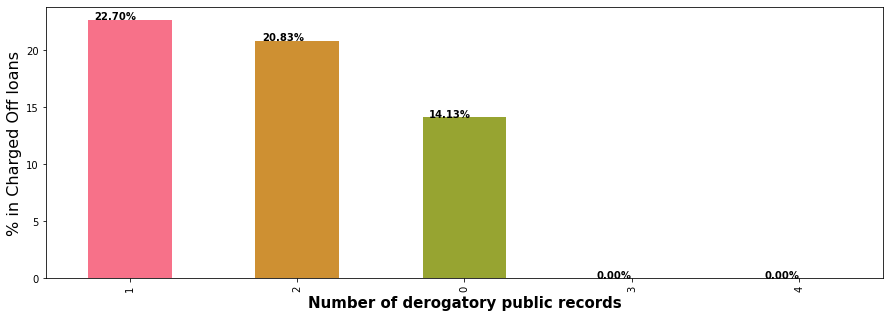

In [790]:
#percentage of charged off for Public derogatory records
plot_percentages(loan_data,'pub_rec')
plt.xlabel('Number of derogatory public records',fontweight ='bold',fontsize = 15)

##### Observation
- Borrower with derogatory public records have high chance of charged_off

#### Variable:revol_util
Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit.

In [791]:
loan_data.groupby('revol_util_bin')['loan_status'].value_counts(normalize=True) * 100

revol_util_bin  loan_status
0%-20%          Fully Paid    90.80
                Charged Off    9.20
21%-40%         Fully Paid    88.12
                Charged Off   11.88
41%-60%         Fully Paid    85.30
                Charged Off   14.70
61%-80%         Fully Paid    83.08
                Charged Off   16.92
81%-100%        Fully Paid    79.91
                Charged Off   20.09
Name: loan_status, dtype: float64

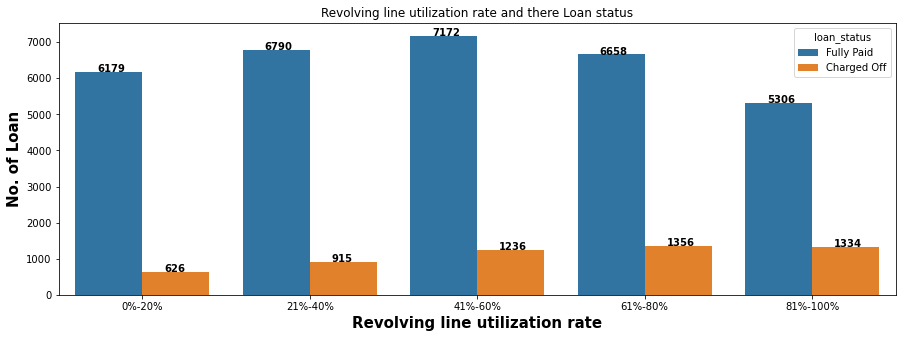

In [792]:
#Number of loan for Revolving line utilization rate and there loan status loan status
plt.figure(figsize=(15,5))
ax=sns.countplot(x=loan_data['revol_util_bin'],hue=loan_data['loan_status'])
plt.xlabel('Revolving line utilization rate',fontweight ='bold',fontsize = 15)
plt.ylabel('No. of Loan',fontweight ='bold',fontsize = 15)
plt.title('Revolving line utilization rate and there Loan status')
for p in ax.patches:
        ax.annotate((p.get_height()), (p.get_x()+0.13, p.get_height()),fontweight ='bold')

##### Observation:
- Borrower with revolving rate between 81% to 100% have 20.09% charged off.

#### Variable:total_acc
The total number of credit lines currently in the borrower's credit file

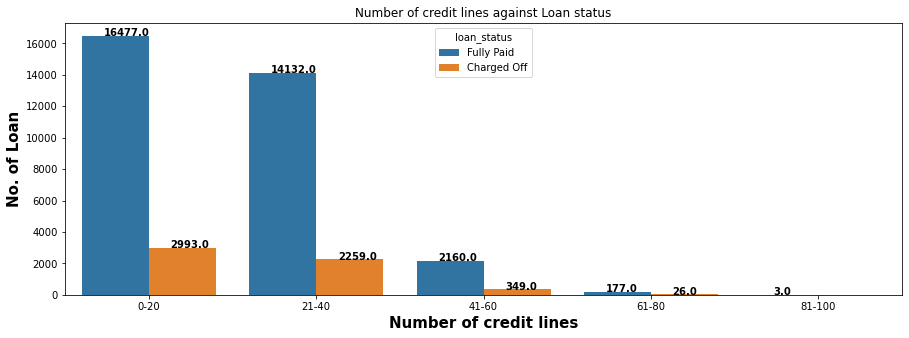

In [793]:
#Number of credit lines and there loan status
plt.figure(figsize=(15,5))
ax=sns.countplot(x=loan_data['total_acc_bin'],hue=loan_data['loan_status'])
plt.xlabel('Number of credit lines',fontweight ='bold',fontsize = 15)
plt.ylabel('No. of Loan',fontweight ='bold',fontsize = 15)
plt.title('Number of credit lines against Loan status')
for p in ax.patches:
        ax.annotate((p.get_height()), (p.get_x()+0.13, p.get_height()),fontweight ='bold')

In [794]:
loan_data.groupby('total_acc_bin')['loan_status'].value_counts(normalize=True) * 100

total_acc_bin  loan_status
0-20           Fully Paid     84.63
               Charged Off    15.37
21-40          Fully Paid     86.22
               Charged Off    13.78
41-60          Fully Paid     86.09
               Charged Off    13.91
61-80          Fully Paid     87.19
               Charged Off    12.81
81-100         Fully Paid    100.00
Name: loan_status, dtype: float64

#### Variable:
- total_pymnt : Payments received to date for total amount funded
- total_pymnt_inv : Payments received to date for portion of total amount funded by investors
- total_rec_prncp : Principal received to date
- total_rec_int : Interest received to date

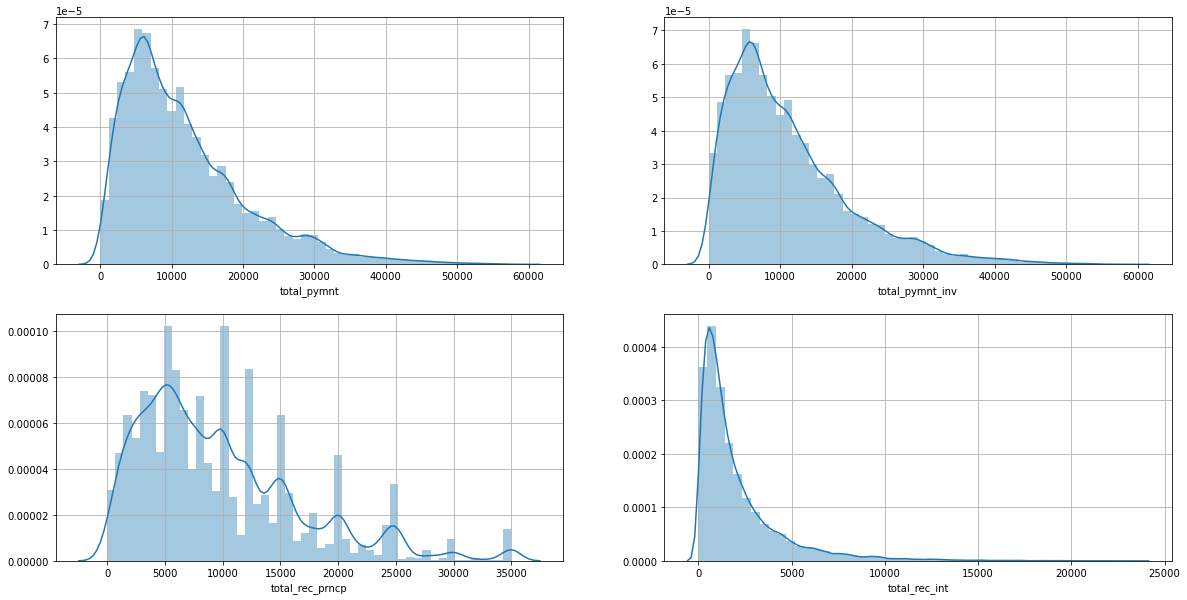

In [795]:
#Distplot for total_pymnt, total_pymnt_inv, total_rec_prncp, and total_rec_int
plt.figure(figsize=(20,10)) 
plt.subplot(2, 2, 1)
plt.grid()
ax = sns.distplot(loan_data['total_pymnt'])
plt.subplot(2, 2, 2)
plt.grid()
ax = sns.distplot(loan_data['total_pymnt_inv'])
plt.subplot(2, 2, 3)
plt.grid()
ax = sns.distplot(loan_data['total_rec_prncp'])
plt.subplot(2, 2, 4)
plt.grid()
ax = sns.distplot(loan_data['total_rec_int'])
plt.show()


#### Variable: pub_rec_bankruptcies
Number of public record bankruptcies

In [796]:
loan_data['pub_rec_bankruptcies'].value_counts()

0.00    36238
1.00     1637
2.00        5
Name: pub_rec_bankruptcies, dtype: int64

Text(0.5, 0, 'Number of public record bankruptcies')

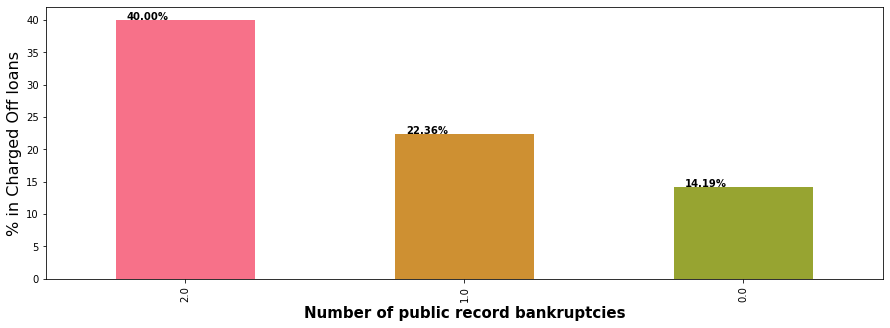

In [797]:
#percentage of  charged off for public record bankruptcies
plot_percentages(loan_data,'pub_rec_bankruptcies')
plt.xlabel('Number of public record bankruptcies',fontweight ='bold',fontsize = 15)

##### Observation:
- Borrower with bankruptcies record have high percentage of charged off.

# Bivariate analysis

#### Variable: loan_amnt, int_rate, and loan_status

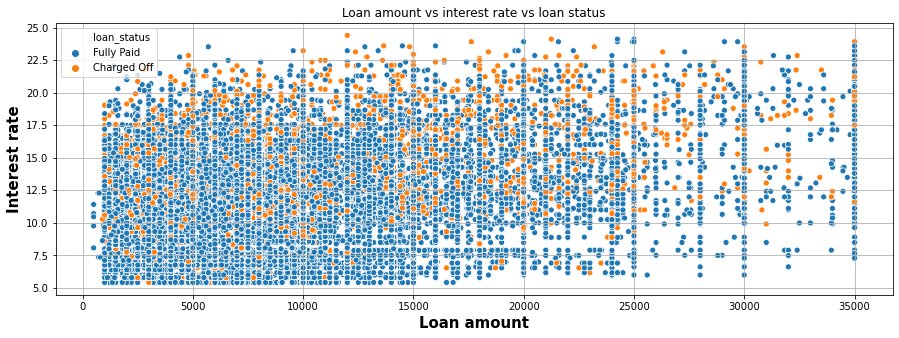

In [798]:
#Loan amount vs interest rate vs loan status
plt.figure(figsize=(15,5)) 
sns.scatterplot(x=loan_data['loan_amnt'],y=loan_data['int_rate'],hue=loan_data['loan_status'])
plt.xlabel('Loan amount',fontweight ='bold',fontsize = 15)
plt.ylabel('Interest rate',fontweight ='bold',fontsize = 15)
plt.title('Loan amount vs interest rate vs loan status')
plt.grid()
plt.show()

##### Observation: 
- For higher loan amount there is higher interest rate
- More charged off loan for higher interest rate.

#### Variable: loan_amnt, int_rate, term

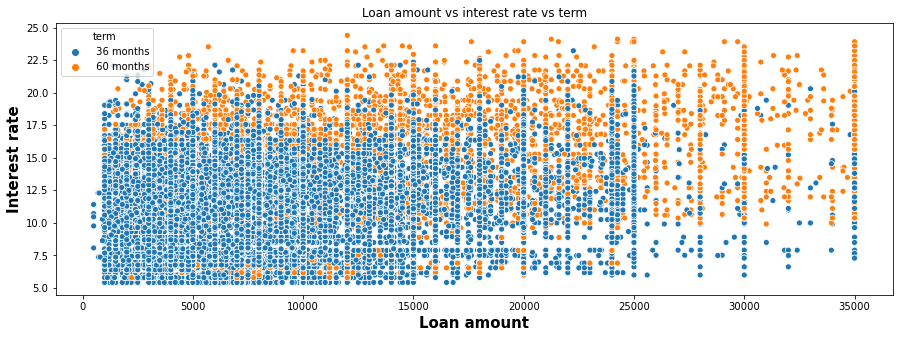

In [799]:
#Loan amount vs interest rate vs term
plt.figure(figsize=(15,5)) 
sns.scatterplot(x=loan_data['loan_amnt'],y=loan_data['int_rate'],hue=loan_data['term'])
plt.xlabel('Loan amount',fontweight ='bold',fontsize = 15)
plt.ylabel('Interest rate',fontweight ='bold',fontsize = 15)
plt.title('Loan amount vs interest rate vs term')
plt.show()

##### Observation: 
- For higher interest there are more 60 months term loan
- For higher loan amount most of the loan term is 60 months

#### Variable: loan_amnt, installment, and loan_status

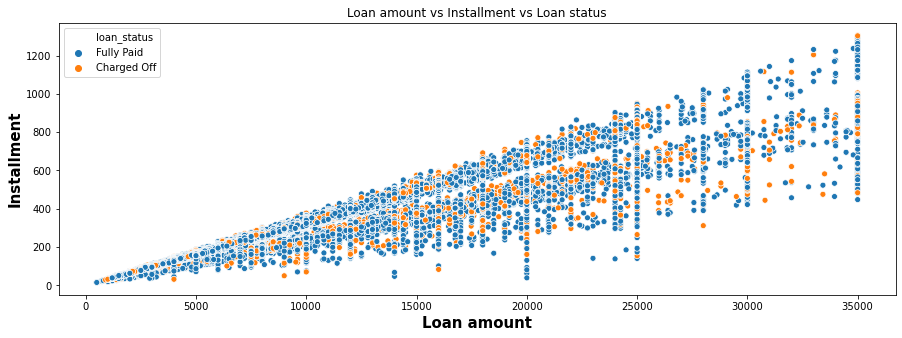

In [800]:
#Loan amount vs installment vs loan status
plt.figure(figsize=(15,5)) 
sns.scatterplot(x=loan_data['loan_amnt'],y=loan_data['installment'],hue=loan_data['loan_status'])
plt.xlabel('Loan amount',fontweight ='bold',fontsize = 15)
plt.ylabel('Installment',fontweight ='bold',fontsize = 15)
plt.title('Loan amount vs Installment vs Loan status')
plt.show()

##### Observation:
- Linear relation between loan amount and installment

#### Variable: loan_amnt, int_rate, and loan_status

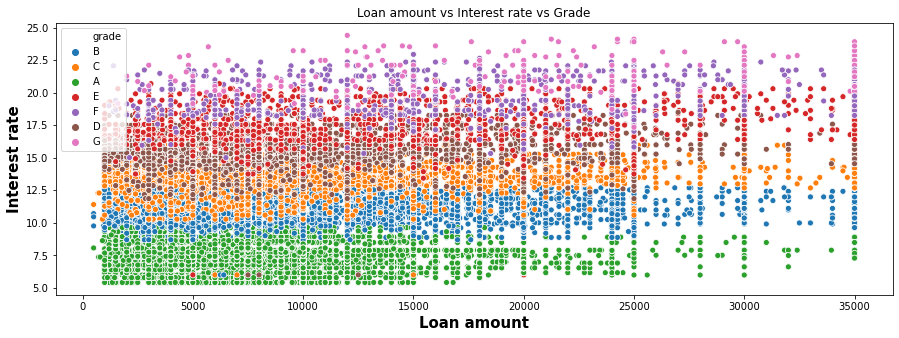

In [801]:
#Loan amount vs Interest rate vs Grade
plt.figure(figsize=(15,5)) 
sns.scatterplot(x=loan_data['loan_amnt'],y=loan_data['int_rate'],hue=loan_data['grade'])
plt.xlabel('Loan amount',fontweight ='bold',fontsize = 15)
plt.ylabel('Interest rate',fontweight ='bold',fontsize = 15)
plt.title('Loan amount vs Interest rate vs Grade')
plt.show()

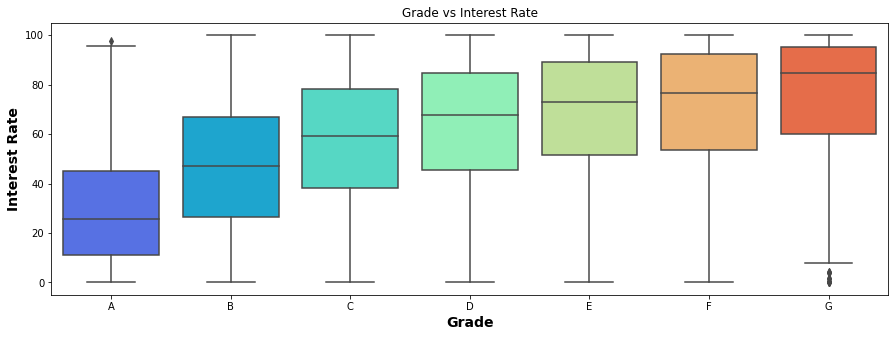

In [802]:
# Grade vs interest rate boxplot
plt.figure(figsize=(15,5))
order1=loan_data.groupby('grade')['int_rate'].mean().sort_values().index
ax = sns.boxplot(x='grade',y='revol_util', data =loan_data,palette='rainbow',order=order1)
ax.set_title('Grade vs Interest Rate')
ax.set_ylabel('Interest Rate',fontweight ='bold',fontsize=14)
ax.set_xlabel('Grade',fontweight ='bold',fontsize=14)
plt.show()

##### Observation:
- Higher average interest rate with increase in grade

#### Variable: sub_grade,int_rate

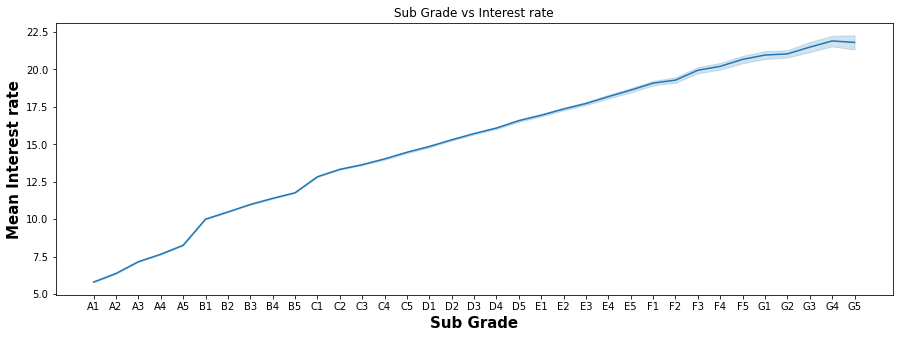

In [803]:
plt.figure(figsize=(15,5))
sns.lineplot(data=loan_data, x="sub_grade", y="int_rate")
plt.xlabel('Sub Grade',fontweight ='bold',fontsize = 15)
plt.ylabel('Mean Interest rate',fontweight ='bold',fontsize = 15)
plt.title('Sub Grade vs Interest rate')
plt.show()

##### Observation:
- Interest rate increases as the Sub grade increases

#### Variable: annual_inc, loan_amnt, and loan_status

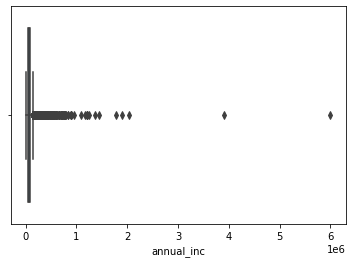

In [804]:
sns.boxplot(x=loan_data['annual_inc'])
plt.show()

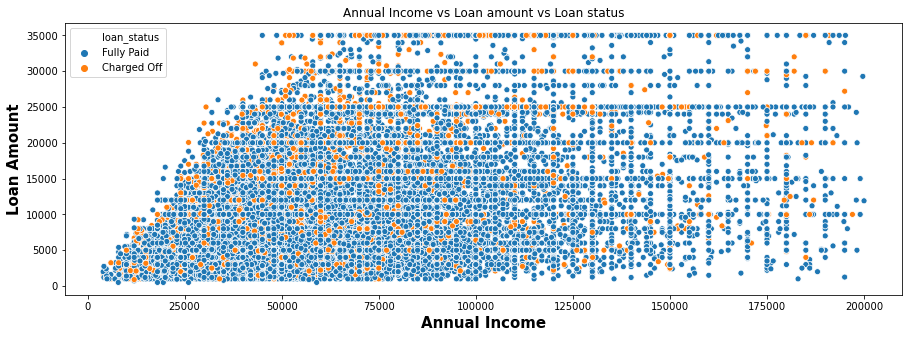

In [805]:
#Annual Income vs Loan amount vs loan status
#Take Annualincome under 2lakh beacuse of outliners
plt.figure(figsize=(15,5))
sns.scatterplot(data=loan_data.loc[loan_data['annual_inc']<200000],x="annual_inc",y="loan_amnt",hue="loan_status")
plt.xlabel('Annual Income',fontweight ='bold',fontsize = 15)
plt.ylabel('Loan Amount',fontweight ='bold',fontsize = 15)
plt.title('Annual Income vs Loan amount vs Loan status')
plt.show()

##### Observation:
- Most loan take by borrower whose annual income is under 150000
- With increase in annual income loan amount increases.

#### Variable: verification_status, loan_amount, loan_status

In [806]:
loan_data.groupby('verification_status')['loan_amnt'].describe()

,count,mean,std,min,25%,50%,75%,max
verification_status,,,,,,,,
Not Verified,16693.00,8387.34,5062.32,500.00,4800.00,7500.00,11300.00,35000.00
Source Verified,9677.00,9970.64,6489.14,1000.00,5000.00,8675.00,13250.00,35000.00
Verified,12206.00,15538.53,8453.83,1000.00,8500.00,15000.00,21000.00,35000.00


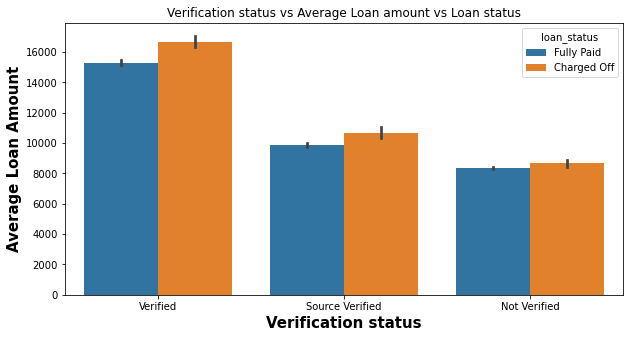

In [807]:
#Loan amount against the verifiaction of borrower annual income with respect to loan status
plt.figure(figsize=(10,5))
sns.barplot(x='verification_status', y='loan_amnt', hue="loan_status", data=loan_data)
plt.xlabel('Verification status',fontweight ='bold',fontsize = 15)
plt.ylabel('Average Loan Amount',fontweight ='bold',fontsize = 15)
plt.title('Verification status vs Average Loan amount vs Loan status')
plt.show()

##### Observation:
- Borrowers with verified annual income on an average get large amount of loans

#### Variable: home_ownership, loan_amnt, and loan_status

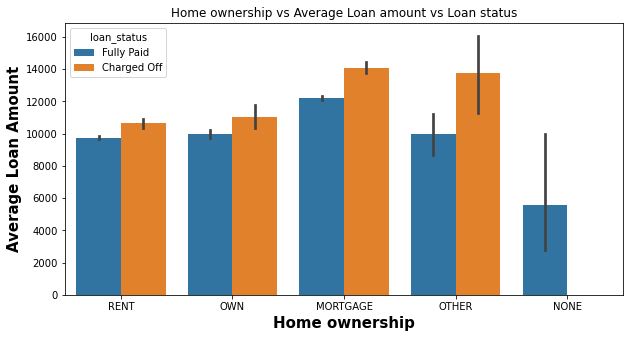

In [808]:
#Loan amount against the home ownership of borrower with respect to loan status
plt.figure(figsize=(10,5))
sns.barplot(x='home_ownership', y='loan_amnt', hue="loan_status", data=loan_data)
plt.xlabel('Home ownership',fontweight ='bold',fontsize = 15)
plt.ylabel('Average Loan Amount',fontweight ='bold',fontsize = 15)
plt.title('Home ownership vs Average Loan amount vs Loan status')
plt.show()

##### Observation:
- On an average borrower with home ownership as Mortgage taken more loan and also the charged off loan amount is higher

#### Variable: purpose, loan_amnt, and loan_status

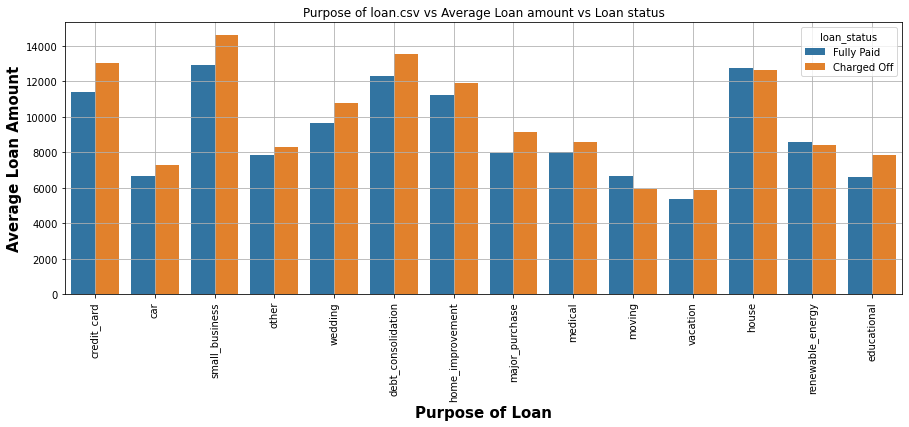

In [809]:
#Purpose of loan against the mean loan amount as per the loan status
plt.figure(figsize=(15,5))
sns.barplot(x='purpose', y='loan_amnt',hue='loan_status',data=loan_data,ci=None)
plt.xlabel('Purpose of Loan',fontweight ='bold',fontsize = 15)
plt.xticks(rotation='vertical')
plt.ylabel('Average Loan Amount',fontweight ='bold',fontsize = 15)
plt.title('Purpose of loan vs Average Loan amount vs Loan status')
plt.grid()
plt.show()

##### Observation: 
- Average loan amount for Small business, Debt Consolidation and house are higher
- Average loan amount charged for small business is higher.

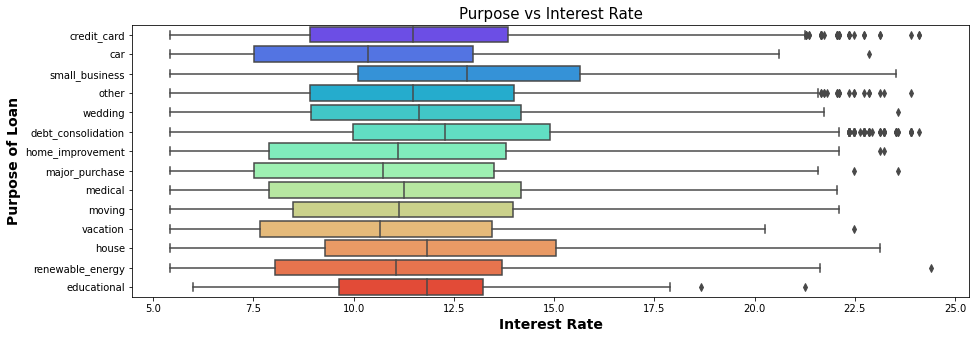

In [810]:
#Purpose vs Interest Rate
plt.figure(figsize=(15,5))
ax = sns.boxplot(x='int_rate', y='purpose', data =loan_data,palette='rainbow')
ax.set_title('Purpose vs Interest Rate',fontsize=15)
ax.set_xlabel('Interest Rate',fontweight ='bold',fontsize=14)
ax.set_ylabel('Purpose of Loan',fontweight ='bold',fontsize=14)
plt.show()

##### Observation:
- Average Interest rate is highest for Small Business and there is high charged off chances.
- For debt consolidation there is more number of loan and a high interest rate.

#### Variable: dti, int_rate

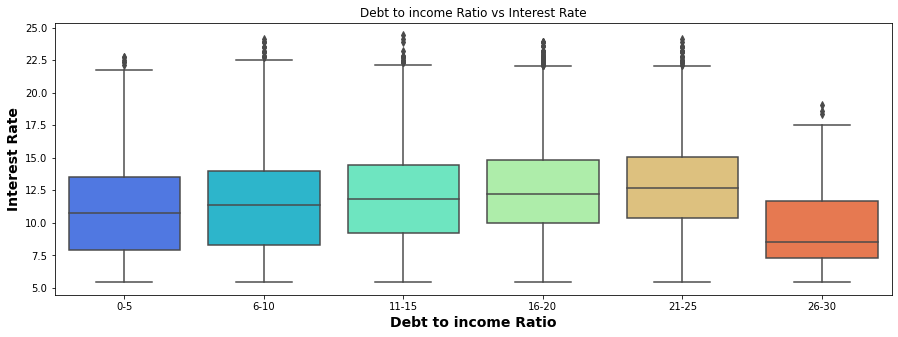

In [811]:
# Dti vs interest rate boxplot
plt.figure(figsize=(15,5))
ax = sns.boxplot( x='dti_bin',y='int_rate', data =loan_data,palette='rainbow')
ax.set_title('Debt to income Ratio vs Interest Rate')
ax.set_ylabel('Interest Rate',fontweight ='bold',fontsize=14)
ax.set_xlabel('Debt to income Ratio',fontweight ='bold',fontsize=14)
plt.show()

##### Observation: 
- As dti increases interest rate also increases
- Except for dti in range 26-30 (can't get exact data because of less number number loan for borrower having dti 26-30)

#### Variable: issued_d_Month, loan_amnt, loan_status

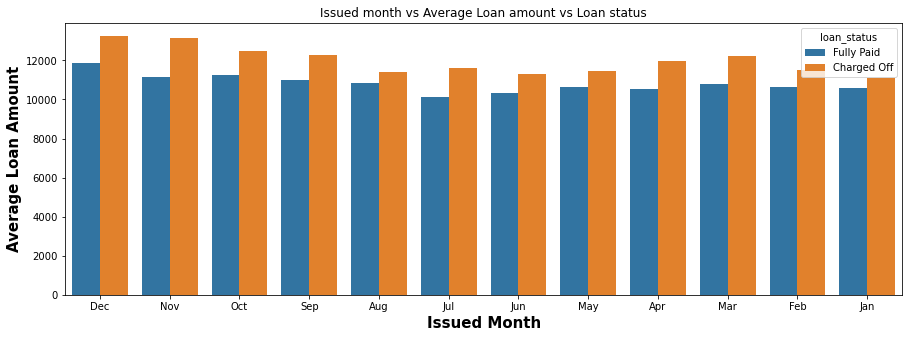

In [812]:
#Month in which loan was borrowed vs the mean loan amount as per the loan status
plt.figure(figsize=(15,5))
sns.barplot(x='issue_d_Month', y='loan_amnt',hue='loan_status',data=loan_data,ci=None)
plt.xlabel('Issued Month',fontweight ='bold',fontsize = 15)
plt.ylabel('Average Loan Amount',fontweight ='bold',fontsize = 15)
plt.title('Issued month vs Average Loan amount vs Loan status')
plt.show()

Text(0.5, 0, 'Issued Month')

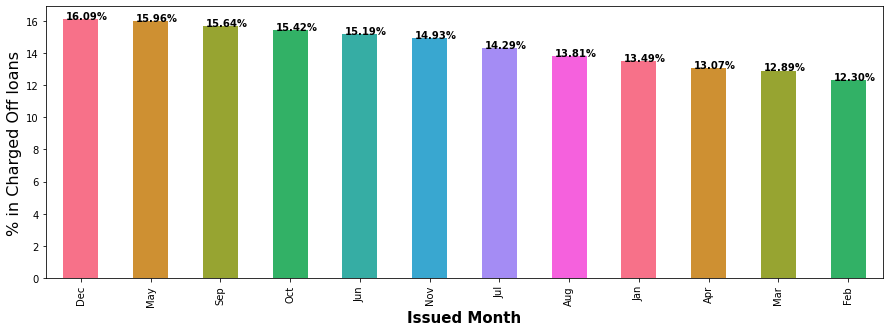

In [813]:
plot_percentages(loan_data,'issue_d_Month')
plt.xlabel('Issued Month',fontweight ='bold',fontsize = 15)

##### Observation:
- Most of issued loan and charged off percentage is higher for December month.

#### Variable: revol_util_bin, int_rate

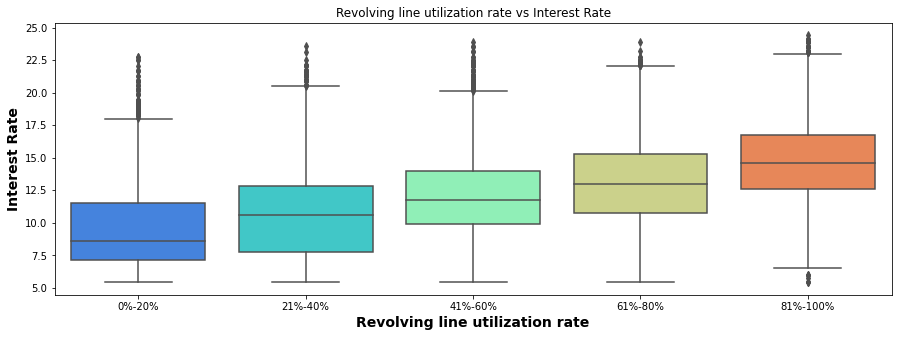

In [814]:
# Revol_util vs interest rate boxplot
plt.figure(figsize=(15,5))
ax = sns.boxplot( x='revol_util_bin',y='int_rate', data =loan_data,palette='rainbow')
ax.set_title('Revolving line utilization rate vs Interest Rate')
ax.set_ylabel('Interest Rate',fontweight ='bold',fontsize=14)
ax.set_xlabel('Revolving line utilization rate',fontweight ='bold',fontsize=14)
plt.show()

##### Observation:
- Borrower with more revolving line utilization rate have to pay more interest for the loan.

## Correlation

In [815]:
#Create a new dataframe
loan_correlation = loan_data.copy()

In [816]:
#replace value in loan_status column
loan_correlation['loan_status'] = loan_correlation['loan_status'].replace({"Charged Off": 1, "Fully Paid": 0})

In [817]:
#replace value in term column
loan_correlation['term'] = loan_correlation['term'].replace({" 36 months": 1, " 60 months": 0})

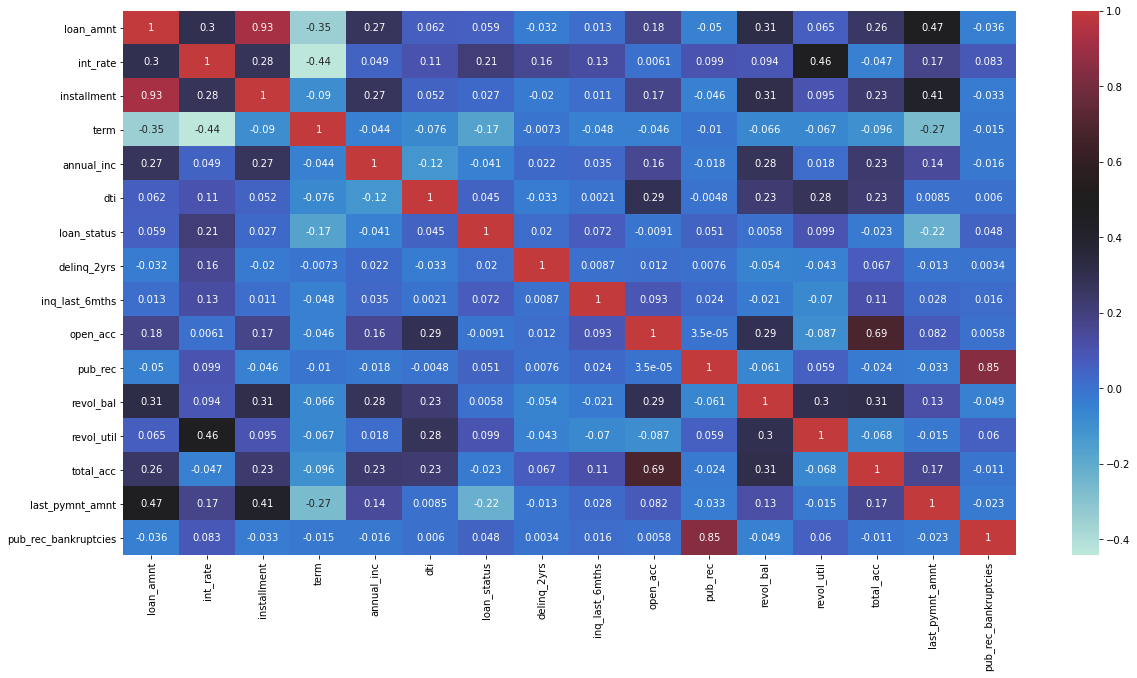

In [818]:
plt.figure(figsize=(20,10))
cont_var= ['loan_amnt', 'int_rate', 'installment','term','annual_inc','dti','loan_status','delinq_2yrs',
           'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util','total_acc',
           'last_pymnt_amnt','pub_rec_bankruptcies']
           
corr = loan_correlation[cont_var].corr()
sns.heatmap(corr, annot=True, center=0.5)